In [1]:
#Cargar Librerías
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import csv
%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
#plt.style.use('fast')

from sklearn.metrics import r2_score
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [2]:
#SACAR R2 ENTRE VALOR PREDIJO (EL MAS CERCANO, EL MÍNIMO) VS REAL
#AGREGAR VARIABLE "MARCA" AGRUPANDO CON LOS MÁS SIGINFICATIVOS Y "OTROS"

In [3]:
#Cargar archivo .CSV con datos de delitos
#Si es necesario, aún no se puede agregar más variables

df = pd.read_csv("/Users/j.artigasalegra/Documents/tesis/Solicitud_Base_Datos/Base_Dato_Con_Coorednadas/DATOS GEOCODIFICADOS/DATOS_RED_CUADRANTE.csv",  parse_dates=[0], index_col=0, names=['Delito','DiaSem', 'Mes', 'Hora', 'TipoV','Marca', 'Comuna', 'Cuadrante'])
df.head(10)

DiaSem  Mes  Hora  TipoV  Marca  Comuna  Cuadrante
Delito                                                    
1            3    1     1      2      2       5         21
3            3    1     5      1      1       2          1
4            3    1     5      4     17       1         12
5            3    1     6      1      2       4          1
6            3    1     8      1      5       1          2
7            3    1     9      3      3       2          8
8            3    1    11      5     10       3         23
9            3    1    13      1      2       1          4
10           3    1    22      2      7       1          6
12           4    1     0      1      1      12          1

In [4]:
df.describe()

DiaSem          Mes         Hora        TipoV        Marca  \
count  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000   
mean      4.003848     6.432106    11.626443     2.015393     6.886201   
std       1.977461     3.434077     7.475914     1.549046     6.018642   
min       1.000000     1.000000     0.000000     1.000000     1.000000   
25%       2.000000     4.000000     5.000000     1.000000     2.000000   
50%       4.000000     6.000000    11.000000     1.000000     4.000000   
75%       6.000000     9.000000    19.000000     3.000000    12.000000   
max       7.000000    12.000000    23.000000     6.000000    17.000000   

            Comuna    Cuadrante  
count  3638.000000  3638.000000  
mean      3.319956     7.767180  
std       2.973699     6.358457  
min       1.000000     1.000000  
25%       1.000000     2.000000  
50%       2.000000     6.000000  
75%       5.000000    11.000000  
max      12.000000    25.000000

In [5]:
df=df.drop(columns=[])
print(df.shape)
df.head()

(3638, 7)


DiaSem  Mes  Hora  TipoV  Marca  Comuna  Cuadrante
Delito                                                    
1            3    1     1      2      2       5         21
3            3    1     5      1      1       2          1
4            3    1     5      4     17       1         12
5            3    1     6      1      2       4          1
6            3    1     8      1      5       1          2

In [6]:
# convertir series a aprendizaje supervizado
#Aprendizaje supervisado será utilizando los 15 días previos para predecir el actual delito (latitud y longitud)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
PASOS = 15

data = df.values
data = data.astype('float32')
scaler = MinMaxScaler()
data = scaler.fit_transform(data[:, :8])
data = pd.DataFrame(data)
data.columns = data.columns
data=data.rename(columns = {0:'Diasem', 1:'Mes', 2:'Hora', 3:'TipoV', 4:'Marca', 5:'Comuna', 6:'Cuadrante'})
data.head()

scaledMerge= data

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
print(reframed.shape)
reframed.head()

(3623, 112)


var1(t-15)  var2(t-15)  var3(t-15)  var4(t-15)  var5(t-15)  var6(t-15)  \
15    0.333333         0.0    0.043478         0.2      0.0625    0.363636   
16    0.333333         0.0    0.217391         0.0      0.0000    0.090909   
17    0.333333         0.0    0.217391         0.6      1.0000    0.000000   
18    0.333333         0.0    0.260870         0.0      0.0625    0.272727   
19    0.333333         0.0    0.347826         0.0      0.2500    0.000000   

    var7(t-15)  var1(t-14)  var2(t-14)  var3(t-14)  ...  var5(t-1)  var6(t-1)  \
15    0.833333    0.333333         0.0    0.217391  ...     0.4375   0.454545   
16    0.000000    0.333333         0.0    0.217391  ...     0.1250   0.090909   
17    0.458333    0.333333         0.0    0.260870  ...     0.0625   0.000000   
18    0.000000    0.333333         0.0    0.347826  ...     0.3750   0.090909   
19    0.041667    0.333333         0.0    0.391304  ...     1.0000   0.000000   

    var7(t-1)   var1(t)  var2(t)   var3(t)  var4(t)  var5(t)   var6(t)  \
15   0.041667  0.666667      0.0  0.782609      0.0   0.1250  0.090909   
16   0.000000  0.666667      0.0  0.913043      0.0   0.0625  0.000000   
17   0.000000  0.666667      0.0  0.956522      0.0   0.3750  0.090909   
18   0.000000  0.666667      0.0  0.956522      1.0   1.0000  0.000000   
19   0.416667  0.833333      0.0  0.173913      0.0   1.0000  0.181818   

     var7(t)  
15  0.000000  
16  0.000000  
17  0.000000  
18  0.416667  
19  0.333333  

[5 rows x 112 columns]

In [8]:
#Se elimina las otras variables en perido t para solo tener como salida Longitud y Latitud

newReframed=reframed.drop(columns=['var1(t)','var2(t)','var3(t)','var4(t)', 'var5(t)', 'var6(t)'])
print(newReframed.shape)
newReframed.head()

(3623, 106)


var1(t-15)  var2(t-15)  var3(t-15)  var4(t-15)  var5(t-15)  var6(t-15)  \
15    0.333333         0.0    0.043478         0.2      0.0625    0.363636   
16    0.333333         0.0    0.217391         0.0      0.0000    0.090909   
17    0.333333         0.0    0.217391         0.6      1.0000    0.000000   
18    0.333333         0.0    0.260870         0.0      0.0625    0.272727   
19    0.333333         0.0    0.347826         0.0      0.2500    0.000000   

    var7(t-15)  var1(t-14)  var2(t-14)  var3(t-14)  ...  var6(t-2)  var7(t-2)  \
15    0.833333    0.333333         0.0    0.217391  ...   0.000000   0.083333   
16    0.000000    0.333333         0.0    0.217391  ...   0.454545   0.041667   
17    0.458333    0.333333         0.0    0.260870  ...   0.090909   0.000000   
18    0.000000    0.333333         0.0    0.347826  ...   0.000000   0.000000   
19    0.041667    0.333333         0.0    0.391304  ...   0.090909   0.000000   

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
15   0.666667        0.0   0.782609        0.0     0.4375   0.454545   
16   0.666667        0.0   0.782609        0.0     0.1250   0.090909   
17   0.666667        0.0   0.913043        0.0     0.0625   0.000000   
18   0.666667        0.0   0.956522        0.0     0.3750   0.090909   
19   0.666667        0.0   0.956522        1.0     1.0000   0.000000   

    var7(t-1)   var7(t)  
15   0.041667  0.000000  
16   0.000000  0.000000  
17   0.000000  0.000000  
18   0.000000  0.416667  
19   0.416667  0.333333  

[5 rows x 106 columns]

In [9]:
#Separar datos como datos de entrenamiento y datos de prueba 
#Separa los datos en 80% (1700) train y 20% (725) validación

values = newReframed.values
train = values[0:3260, :]
test = values[3260:3628, :]

# split into input and outputs

x_train, y_train = train[:, 0:105], train[:, 105:106]
x_val, y_val = test[:, 0:105], test[:, 105:106]

# reshape input to be 3D [samples, timesteps, features]
#x_train = x_train.reshape((x_train.shape[0], 1,x_train.shape[1]))
#x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(3260, 105) (3260, 1) (363, 105) (363, 1)


In [10]:
#Se define la red neuronal, cuando tenga la red lista, probare con distintas funciones de activación o nodos

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(105, input_dim=(105), kernel_initializer='normal',activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [11]:
#Despues de tener lista la red, variare EPOCHS para ver como mejoran los resultados
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 105)               11130     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 106       
Total params: 11,236
Trainable params: 11,236
Non-trainable params: 0
_________________________________________________________________
Train on 3260 samples, validate on 363 samples
Epoch 1/40
3260/3260 [==============================] - 5s 2ms/sample - loss: 0.2152 - mse: 0.0765 - val_loss: 0.2163 - val_mse: 0.0787
Epoch 2/40
3260/3260 [==============================] - 4s 1ms/sample - loss: 0.2124 - mse: 0.0748 - val_loss: 0.2163 - val_mse: 0.0783
Epoch 3/40
3260/3260 [==============================] - 4s 1ms/sample - loss: 0.2117 - mse: 0.0749 - val_loss: 0.2181 - val_mse: 0.0801
Epoch 4/40
3260/3260 [==============================] - 4s 

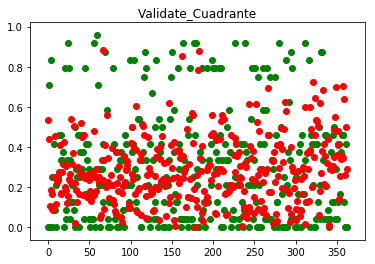

In [12]:
#Renombrar columnas de variable predicha y validación

results=model.predict(x_val)
results = pd.DataFrame(results)
results.columns = results.columns
results=results.rename(columns = {0:'Cuadrante'})
#print(results)

y_val = pd.DataFrame(y_val)
y_val.columns = y_val.columns
y_val=y_val.rename(columns = {0:'Cuadrante'})
#print(y_val)

#Permite visualizar que tanto se acerca la predicción con los valores de validación
plt.scatter(range(len(y_val['Cuadrante'])),y_val['Cuadrante'],c='g')
plt.scatter(range(len(results['Cuadrante'])),results['Cuadrante'],c='r')
plt.title('Validate_Cuadrante')
plt.show()

#plt.scatter(range(len(y_val['Latitud'])),y_val['Latitud'],c='g')
#plt.scatter(range(len(results['Latitud'])),results['Latitud'],c='r')
#plt.title('Validate_Latitud')
#plt.show()

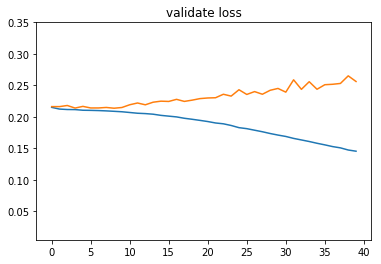

In [13]:
#Permite graficar la pérdida LOSS tanto del conjunto de ENTENAMIENTO(azul)  como de VALIDACION(naranja)

plt.ylim(0.005, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

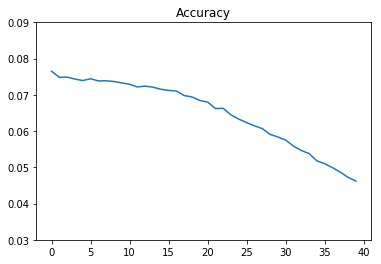

In [14]:
plt.ylim(0.03, 0.09)
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [15]:
print(results)

     Cuadrante
0     0.536550
1     0.438303
2     0.105350
3     0.183716
4     0.088787
5     0.166196
6     0.088964
7     0.252111
8     0.454326
9     0.244032
10    0.113612
11    0.227108
12    0.234383
13    0.274003
14    0.408027
15    0.167435
16    0.172159
17    0.272877
18    0.314121
19    0.422852
20    0.199837
21    0.303883
22    0.182885
23    0.121790
24    0.155020
25    0.240805
26    0.231349
27    0.265130
28    0.539118
29    0.316495
..         ...
333   0.683472
334   0.215823
335   0.417064
336   0.353041
337   0.203481
338   0.317472
339   0.438421
340   0.009460
341   0.006451
342   0.292053
343   0.303572
344   0.286130
345   0.306342
346   0.350580
347   0.483478
348   0.548801
349   0.698522
350   0.357863
351   0.409800
352   0.477292
353   0.141773
354   0.253558
355   0.341742
356   0.357010
357   0.702634
358   0.347031
359   0.637617
360   0.258314
361   0.501801
362   0.289505

[363 rows x 1 columns]


In [16]:
#Agregar 4 columnas falsasa para poder invertir valores a original

results['Var2'] = results['Cuadrante']
results['Var3'] = results['Cuadrante']
results['Var4'] = results['Cuadrante']
results['Var5'] = results['Cuadrante']
results['Var6'] = results['Cuadrante']
results['Var7'] = results['Cuadrante']
print(results)

y_val['Var2'] = y_val["Cuadrante"]
y_val['Var3'] = y_val["Cuadrante"]
y_val['Var4'] = y_val["Cuadrante"]
y_val['Var5'] = y_val["Cuadrante"]
y_val['Var6'] = y_val["Cuadrante"]
y_val['Var7'] = y_val["Cuadrante"]
print(y_val)

     Cuadrante      Var2      Var3      Var4      Var5      Var6      Var7
0     0.536550  0.536550  0.536550  0.536550  0.536550  0.536550  0.536550
1     0.438303  0.438303  0.438303  0.438303  0.438303  0.438303  0.438303
2     0.105350  0.105350  0.105350  0.105350  0.105350  0.105350  0.105350
3     0.183716  0.183716  0.183716  0.183716  0.183716  0.183716  0.183716
4     0.088787  0.088787  0.088787  0.088787  0.088787  0.088787  0.088787
5     0.166196  0.166196  0.166196  0.166196  0.166196  0.166196  0.166196
6     0.088964  0.088964  0.088964  0.088964  0.088964  0.088964  0.088964
7     0.252111  0.252111  0.252111  0.252111  0.252111  0.252111  0.252111
8     0.454326  0.454326  0.454326  0.454326  0.454326  0.454326  0.454326
9     0.244032  0.244032  0.244032  0.244032  0.244032  0.244032  0.244032
10    0.113612  0.113612  0.113612  0.113612  0.113612  0.113612  0.113612
11    0.227108  0.227108  0.227108  0.227108  0.227108  0.227108  0.227108
12    0.234383  0.234383 

In [17]:
#Primero se inviernten los valores de "y_val" y "results" a su valor original
inverted_res = scaler.inverse_transform(results.values)
compara_res = pd.DataFrame(inverted_res)

inverted_y_val = scaler.inverse_transform(y_val.values)
compara_y_val = pd.DataFrame(inverted_y_val)

#Segundo se asgina nombre a las columnas de cada variable
compara_y_val=compara_y_val.rename(columns = {0:'Falso1', 1:'Falso2', 2:'Falso3', 3:'Falso4', 4:'Falso5', 5:'Falso6', 6:'Cuadrante'})
compara_res=compara_res.rename(columns = {0:'Falso1', 1:'Falso2', 2:'Falso3', 3:'Falso4', 4:'Falso5', 5:'Falso6', 6:'Cuadrante'})

#Tercero se eliminan las variables no necesarias
compara_res = compara_res.drop(['Falso1', 'Falso2', 'Falso3', 'Falso4', 'Falso5', 'Falso6'], axis=1)
compara_y_val = compara_y_val.drop(['Falso1', 'Falso2', 'Falso3', 'Falso4', 'Falso5', 'Falso6'], axis=1)
#print(compara_y_val)
#print(compara_res)

#Cuarto crea variable "diferencia" entre valores de resultado y validación, tanto para longitud como latitud
diferencia_lon = compara_res['Cuadrante'] - compara_y_val['Cuadrante']
#diferencia_lat  = compara_res['Latitud'] - compara_y_val['Latitud']
print(diferencia_lon)
#print(diferencia_lat)

0      12.877189
1      -6.480735
2       2.528400
3     -15.590820
4      -3.869112
5       3.988694
6       0.135140
7      -3.949346
8       8.903814
9       0.856772
10      2.726679
11     -0.549417
12     -0.374811
13     -4.423918
14     -1.207360
15     -6.981550
16     -3.868178
17     -1.450961
18     -1.461093
19     10.148436
20    -14.203918
21      6.293180
22      2.389245
23     -5.077049
24    -18.279522
25    -13.220689
26     -2.447615
27      5.363123
28      9.938839
29      2.595868
         ...    
333     8.403332
334     4.179751
335     5.009538
336    -2.527005
337    -6.116456
338     6.619324
339     8.522101
340    -0.772954
341     0.154815
342     6.009262
343    -1.714273
344     3.867123
345    -3.647799
346    -3.586087
347     8.603467
348    12.171223
349     9.764526
350     7.588718
351    -0.164806
352     8.455014
353    -6.597437
354     2.085397
355    -0.798198
356    -2.431767
357     5.863214
358    -2.671252
359    12.302795
360     6.1995

In [18]:
r2_score(compara_y_val, compara_res, multioutput='variance_weighted')

-0.49807892412682775

In [19]:
r2_score(compara_y_val['Cuadrante'], compara_res['Cuadrante'])

-0.49807892412682775

In [20]:
#r2_score(compara_y_val['Latitud'], compara_res['Latitud'])

In [21]:
#Compara Longitudes reales, predichos y su diferencia.
compara_lon = pd.DataFrame(np.array([compara_y_val['Cuadrante'], compara_res['Cuadrante']])).transpose()
compara_lon.columns = ['real', 'prediccion']

compara_lon2 = pd.DataFrame(compara_lon)
compara_lon2.columns = ['real', 'prediccion']
compara_lon2['diferencia'] = diferencia_lon
compara_lon2.head(10)

real  prediccion  diferencia
0   1.0   13.877189   12.877189
1  18.0   11.519265   -6.480735
2   1.0    3.528400    2.528400
3  21.0    5.409180  -15.590820
4   7.0    3.130888   -3.869112
5   1.0    4.988694    3.988694
6   3.0    3.135140    0.135140
7  11.0    7.050654   -3.949346
8   3.0   11.903814    8.903814
9   6.0    6.856772    0.856772

In [22]:
#Compara Latitudes reales, predichos y su diferencia.
#compara_lat = pd.DataFrame(np.array([compara_y_val['Latitud'], compara_res['Latitud']])).transpose()
#compara_lat.columns = ['real', 'prediccion']

#compara_lat2 = pd.DataFrame(compara_lat)
#compara_lat2.columns = ['real', 'prediccion']
#compara_lat2['diferencia'] = diferencia_lat
#compara_lat2.head(10)

In [23]:
#Descarga archivo .CSV con predicción de longitud y latitud

prediccion_lon = pd.DataFrame(compara_lon2)
prediccion_lon.to_csv('7v_15d_40e_pronostico_Cuadrante.csv')

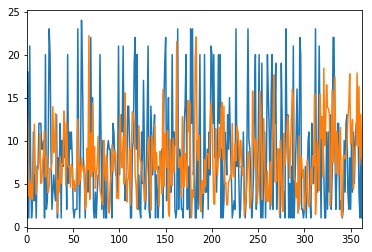

In [24]:
#Gráfico de los resultados de la predicción versus los datos reales
#de variable "Longitud del delito"

compara_lon['real'].plot() #Color azul
compara_lon['prediccion'].plot() #Color naranjo